# VGG16 and InceptionV3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
VGG16 Predicted Class: Truck
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
InceptionV3 Predicted Class: Truck


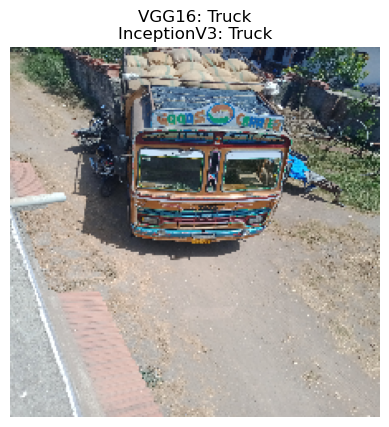

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the models
vgg16_model_path = 'E:/Vehicle/model/vgg16_model.h5'
inceptionv3_model_path = 'E:/Vehicle/model/inceptionv3_model.h5'

vgg16_model = load_model(vgg16_model_path)
inceptionv3_model = load_model(inceptionv3_model_path)

# Load and preprocess the image
image_path = r'E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (16).jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  # Resize the image to match your model's input size
image_normalized = image / 255.0  # Normalize the pixel values
image_expanded = np.expand_dims(image_normalized, axis=0)  # Add a batch dimension

# Class labels
class_labels = ["Auto", "Bus", "Tempo Traveller", "Tractor", "Truck"]

# Predict using VGG16
vgg16_predictions = vgg16_model.predict(image_expanded)
vgg16_predicted_class = np.argmax(vgg16_predictions)
vgg16_predicted_label = class_labels[vgg16_predicted_class]
print("VGG16 Predicted Class:", vgg16_predicted_label)

# Predict using InceptionV3
inceptionv3_predictions = inceptionv3_model.predict(image_expanded)
inceptionv3_predicted_class = np.argmax(inceptionv3_predictions)
inceptionv3_predicted_label = class_labels[inceptionv3_predicted_class]
print("InceptionV3 Predicted Class:", inceptionv3_predicted_label)

# Display the image with predictions
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f'VGG16: {vgg16_predicted_label}\nInceptionV3: {inceptionv3_predicted_label}')
plt.axis('off')
plt.show()


# ResNet50

C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Test Accuracy: 61.74%


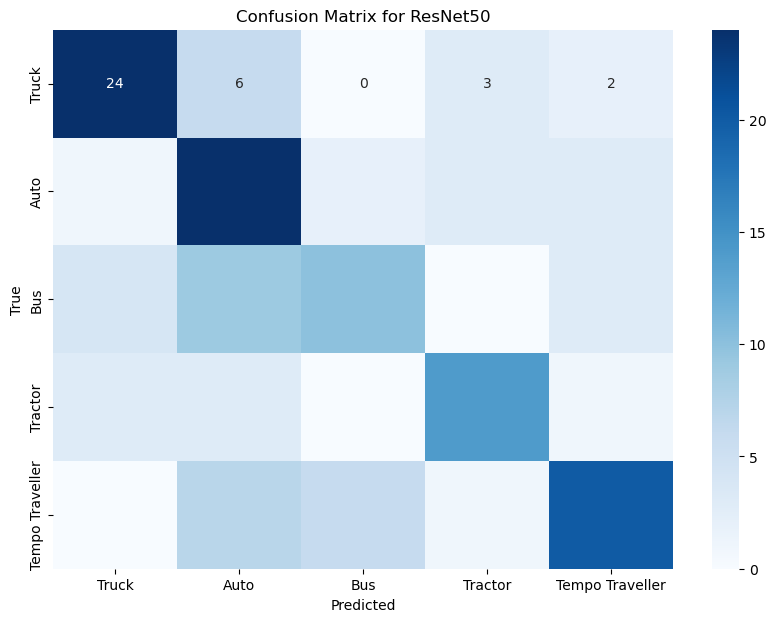

                 precision    recall  f1-score   support

          Truck       0.75      0.69      0.72        35
           Auto       0.49      0.73      0.59        33
            Bus       0.56      0.38      0.45        26
        Tractor       0.67      0.67      0.67        21
Tempo Traveller       0.69      0.59      0.63        34

       accuracy                           0.62       149
      macro avg       0.63      0.61      0.61       149
   weighted avg       0.63      0.62      0.62       149



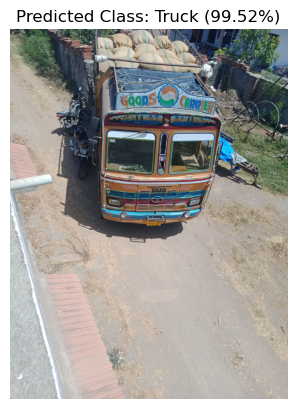

Predicted Class: Truck with Prediction Accuracy: 99.52%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function to load the model
def load_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Define a custom dataset class
class VehicleDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Filepath']
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError) as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.dataframe))
        
        label = self.dataframe.iloc[idx]['Label']
        label = label_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define a function to predict the class of an image
def predict_image(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted_class_idx = predicted.item()
        predicted_label = idx_to_label[predicted_class_idx]
        accuracy = probabilities[0][predicted_class_idx].item() * 100

    img_cv2 = cv2.imread(image_path)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_cv2)
    plt.title(f'Predicted Class: {predicted_label} ({accuracy:.2f}%)')
    plt.axis('off')
    plt.show()

    return predicted_label, accuracy

# Define a function to evaluate the model accuracy on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# Load the label mappings
train_df = pd.read_csv('E:/Vehicle/train_df.csv')
label_to_idx = {label: idx for idx, label in enumerate(train_df['Label'].unique())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Load the model
model_path = 'E:/Vehicle/model/resnet50_model.pth'
num_classes = len(label_to_idx)
model = load_model(model_path, num_classes)

# Load the test dataset
test_df = pd.read_csv('E:/Vehicle/test_df.csv')
test_dataset = VehicleDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
test_accuracy, all_labels, all_preds = evaluate_model(model, test_loader)
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ResNet50')
plt.show()

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=list(label_to_idx.keys())))

# Example usage: predict and display the class of a single image
image_path = r'E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (16).jpg'
predicted_label, accuracy = predict_image(model, image_path, transform)
print(f"Predicted Class: {predicted_label} with Prediction Accuracy: {accuracy:.2f}%")


# InceptionV3 Cuda

C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Model Test Accuracy: 61.07%


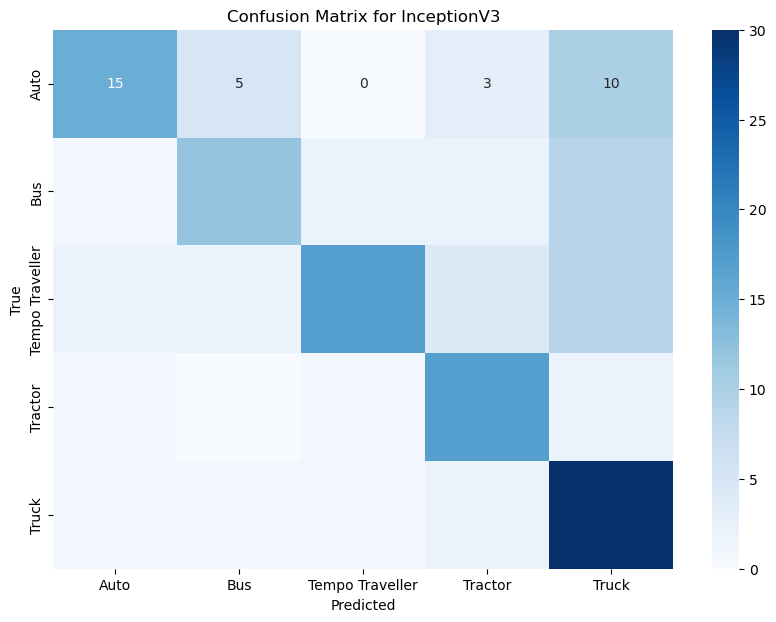

                 precision    recall  f1-score   support

           Auto       0.75      0.45      0.57        33
            Bus       0.60      0.46      0.52        26
Tempo Traveller       0.81      0.50      0.62        34
        Tractor       0.61      0.81      0.69        21
          Truck       0.50      0.86      0.63        35

       accuracy                           0.61       149
      macro avg       0.65      0.62      0.61       149
   weighted avg       0.66      0.61      0.60       149



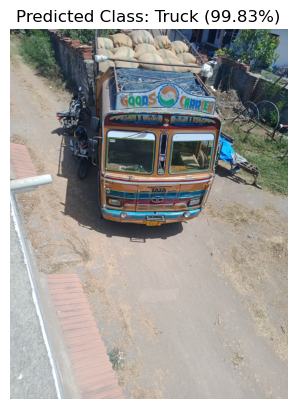

Predicted Class: Truck with Prediction Accuracy: 99.83%


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function to load the model
def load_model(model_path, num_classes):
    model = models.inception_v3(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes),
        nn.LogSoftmax(dim=1)
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Define a custom dataset class
class VehicleDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.dataframe['Label'] = self.label_encoder.fit_transform(self.dataframe['Label'])
        self.idx_to_label = {idx: label for idx, label in enumerate(self.label_encoder.classes_)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Filepath']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.dataframe))
        
        label = self.dataframe.iloc[idx]['Label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def get_class_names(self):
        return list(self.idx_to_label.values())

# Define a function to predict the class of an image
def predict_image(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted_class_idx = predicted.item()
        predicted_label = idx_to_label[predicted_class_idx]
        accuracy = probabilities[0][predicted_class_idx].item() * 100

    img_cv2 = cv2.imread(image_path)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_cv2)
    plt.title(f'Predicted Class: {predicted_label} ({accuracy:.2f}%)')
    plt.axis('off')
    plt.show()

    return predicted_label, accuracy

# Define a function to evaluate the model accuracy on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# Load the label mappings
train_df = pd.read_csv('E:/Vehicle/train_df.csv')
test_df = pd.read_csv('E:/Vehicle/test_df.csv')

# Initialize the dataset to encode labels
train_dataset = VehicleDataset(train_df)
label_to_idx = {label: idx for idx, label in enumerate(train_dataset.get_class_names())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Load the model
model_path = 'E:/Vehicle/Cuda/models/inceptionv3_cuda_model.pth'
num_classes = len(label_to_idx)
model = load_model(model_path, num_classes)

# Load the test dataset
test_dataset = VehicleDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
test_accuracy, all_labels, all_preds = evaluate_model(model, test_loader)
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for InceptionV3')
plt.show()

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=list(label_to_idx.keys())))

# Example usage: predict and display the class of a single image
image_path = r'E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (16).jpg'
predicted_label, accuracy = predict_image(model, image_path, transform)
print(f"Predicted Class: {predicted_label} with Prediction Accuracy: {accuracy:.2f}%")
